# Librairies

In [1]:
from src.import_data import import_data
from src.preprocessing import PreprocessDataTrainTestSplit, EmbeddingData
from src.classifier import RegexClassifier, StoClassifier, CustomXGBPredictor
from src.confusion_matrix import make_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from transformers import CamembertModel, CamembertTokenizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Import and process data

In [2]:
df_corpus = import_data()
df_corpus.head()

,surname,firstname,occupation,age,civil_status,nationality,page,y,link,birth_date,lob,employer,observation
0,Breton,Cyrille,menuisier,25,Garçon,française,1,0,NaN,NaN,NaN,NaN,NaN
1,Ferazzi,Auguste,vitrier,30,Garçon,Piémontaise,1,1,NaN,NaN,NaN,NaN,NaN
2,Machol,Pierre,vitrier,24,Garçon,Piémontaise,1,1,NaN,NaN,NaN,NaN,NaN
3,Desbois,Alexandre,prop re,48,Homme marié,française,1,1,NaN,NaN,NaN,NaN,NaN
4,Vignat,Zélie,prop re,30,NaN,française,1,0,sa fe,NaN,NaN,NaN,NaN


In [3]:
preprocess_train_test = PreprocessDataTrainTestSplit(df = df_corpus,
                                                     index_test = 17814,
                                                     col_to_delete = ["observation", "employer"])

train_df, test_df = preprocess_train_test.run()
print("Train size: {}%".format((len(train_df)*100)/len(df_corpus)))
print("Test size: {}%".format((len(test_df)*100)/len(df_corpus)))

Final test index: 17786
Number of rows with only NaN - Train: 235
Number of rows with only NaN - Test: 138
Train size: 68.968091795033%
Test size: 29.566174159069476%


In [4]:
train_df_link_known = train_df[~train_df["link"].isna()]
train_df_link_unknown = train_df[train_df["link"].isna()]

test_df_link_known = test_df[~test_df["link"].isna()]
test_df_link_unknown = test_df[test_df["link"].isna()]

# Prediction when 'link' variable is known

In [5]:
display(train_df_link_known["y"].value_counts()/len(train_df_link_known))

0    0.783512
1    0.216488
Name: y, dtype: float64

In [6]:
%%time
regclassifier_train = RegexClassifier(df = train_df_link_known,
                                      col_link = "link")

regclassifier_test = RegexClassifier(df = test_df_link_known,
                                     col_link = "link")

y_pred_train_known = regclassifier_train.predict()
y_pred_test_known = regclassifier_test.predict()

acc_train_known = accuracy_score(train_df_link_known["y"], y_pred_train_known)
bal_acc_train_known = balanced_accuracy_score(train_df_link_known["y"], y_pred_train_known)
recall_train_known = recall_score(train_df_link_known["y"], y_pred_train_known)
precision_train_known = precision_score(train_df_link_known["y"], y_pred_train_known)
f1_train_known = f1_score(train_df_link_known["y"], y_pred_train_known)

acc_test_known = accuracy_score(test_df_link_known["y"], y_pred_test_known)
bal_acc_test_known = balanced_accuracy_score(test_df_link_known["y"], y_pred_test_known)
recall_test_known = recall_score(test_df_link_known["y"], y_pred_test_known)
precision_test_known = precision_score(test_df_link_known["y"], y_pred_test_known)
f1_test_known = f1_score(test_df_link_known["y"], y_pred_test_known)

print("Train Accuracy - Link Known: {}".format(acc_train_known))
print("Train Balanced Accuracy - Link Known: {}".format(bal_acc_train_known))
print("Train Recall - Link Known: {}".format(recall_train_known))
print("Train Precision - Link Known: {}".format(precision_train_known))
print("Train F1-score - Link Known: {}\n".format(f1_train_known))

print("Test Accuracy - Link Known: {}".format(acc_test_known))
print("Test Balanced Accuracy - Link Known: {}".format(bal_acc_test_known))
print("Test Recall - Link Known: {}".format(recall_test_known))
print("Test Precision - Link Known: {}".format(precision_test_known))
print("Test F1-score - Link Known: {}".format(f1_test_known))

Train Accuracy - Link Known: 0.9568110824392232
Train Balanced Accuracy - Link Known: 0.9564349637975481
Train Recall - Link Known: 0.955771643663739
Train Precision - Link Known: 0.860248447204969
Train F1-score - Link Known: 0.9054977711738484

Test Accuracy - Link Known: 0.9254106604089842
Test Balanced Accuracy - Link Known: 0.9376693682216328
Test Recall - Link Known: 0.955386289445049
Test Precision - Link Known: 0.6848673946957878
Test F1-score - Link Known: 0.7978191731031349
CPU times: total: 125 ms
Wall time: 263 ms


# Prediction when 'link' variable is unknown

In [7]:
EMBEDDING_DATA = EmbeddingData(df_train = train_df_link_unknown,
                               df_test = test_df_link_unknown,
                               col_age = "age",
                               col_civil_status = "civil_status",
                               col_birth_date = "birth_date",
                               col_nationality = "nationality",
                               col_occupation = "occupation",
                               col_firstname = "firstname",
                               col_surname = "surname"
                               )

EMBEDDING_DATA.clean_train_dataframe()
EMBEDDING_DATA.clean_test_dataframe()

In [8]:
print("Train dataset - link unknown")
display(EMBEDDING_DATA.df_train_clean.head())

Train dataset - link unknown


,age,nationality,civil_status,birth_date,surname,firstname,occupation,page,y,link,lob
0,25.0,4,2,1876.0,[Breton],[Cyrille],[menuisier],1,0,UNK,UNK
1,30.0,1,2,1876.0,[Ferazzi],[Auguste],[vitrier],1,1,UNK,UNK
2,24.0,1,2,1876.0,[Machol],[Pierre],[vitrier],1,1,UNK,UNK
3,48.0,4,3,1876.0,[Desbois],[Alexandre],"[prop, re]",1,1,UNK,UNK
5,24.0,4,1,1876.0,[Houy],[Caroline],[domestique],1,0,UNK,UNK


## Validation

In [9]:
def TSCV_procedure_embedding(n_splits, classifier, embedding_name, embedding_model = None, tokenizer = None, selectfeatures = False, get_features_importance = False, display = False):
    tscv = TimeSeriesSplit(n_splits = n_splits)

    lst_accu_train = []
    lst_bal_accu_train = []
    lst_rec_train = []
    lst_prec_train = []
    lst_f1_train = []
    lst_auc_train = []

    lst_accu_val = []
    lst_bal_accu_val = []
    lst_rec_val = []
    lst_prec_val = []
    lst_f1_val = []
    lst_auc_val = []
    list_dict_features_importance = []

    K = 1
    for train_index, val_index in tscv.split(train_df_link_unknown):
        df_train_fold, df_val_fold = train_df_link_unknown.iloc[train_index], train_df_link_unknown.iloc[val_index]
        EMBEDDING_DATA_fold = EmbeddingData(df_train = df_train_fold,
                                            df_test = df_val_fold,
                                            col_age = "age",
                                            col_civil_status = "civil_status",
                                            col_birth_date = "birth_date",
                                            col_nationality = "nationality",
                                            col_occupation = "occupation",
                                            col_firstname = "firstname",
                                            col_surname = "surname"
                                            )
        EMBEDDING_DATA_fold.clean_train_dataframe()
        EMBEDDING_DATA_fold.clean_test_dataframe()

        sto_clf = StoClassifier(classifier = classifier, model_embedding = embedding_model, name_model_embedding = embedding_name, tokenizer = tokenizer)

        X_train_fold, X_test_fold = sto_clf.fit_embedding(embedding_data = EMBEDDING_DATA_fold,
                                                          col_target = "y",
                                                          selectfeatures = selectfeatures,
                                                          return_x_train = True,
                                                          return_x_test = True)
        if get_features_importance:
            vars_with_no_embedding = ["Age", "Année de naissance", "Nationalité", "Statut"]
            features_names = ["x"+str(i) for i in range(1, X_train_fold.shape[1] - (len(vars_with_no_embedding )- 1))] + ["Age", "Année de naissance", "Nationalité", "Statut"]
            sto_clf.classifier.model.get_booster().feature_names = features_names
            feature_importance_fold = sto_clf.classifier.model.get_booster().get_score(importance_type='weight')
            list_dict_features_importance.append(feature_importance_fold)

        y_pred_train_fold, proba_pred_train_fold, y_pred_val_fold, proba_pred_val_fold = sto_clf.predict(predict_proba = True)

        acc_train_fold = accuracy_score(df_train_fold["y"], y_pred_train_fold)
        bal_acc_train_fold = balanced_accuracy_score(df_train_fold["y"], y_pred_train_fold)
        recall_train_fold = recall_score(df_train_fold["y"], y_pred_train_fold)
        precision_train_fold = precision_score(df_train_fold["y"], y_pred_train_fold)
        f1_train_fold = f1_score(df_train_fold["y"], y_pred_train_fold)
        auc_train_fold = roc_auc_score(df_train_fold["y"], proba_pred_train_fold)

        acc_val_fold = accuracy_score(df_val_fold["y"], y_pred_val_fold)
        bal_acc_val_fold = balanced_accuracy_score(df_val_fold["y"], y_pred_val_fold)
        recall_val_fold = recall_score(df_val_fold["y"], y_pred_val_fold)
        precision_val_fold = precision_score(df_val_fold["y"], y_pred_val_fold)
        f1_val_fold = f1_score(df_val_fold["y"], y_pred_val_fold)
        auc_val_fold = roc_auc_score(df_val_fold["y"], proba_pred_val_fold)

        lst_accu_train.append(acc_train_fold)
        lst_bal_accu_train.append(bal_acc_train_fold)
        lst_rec_train.append(recall_train_fold)
        lst_prec_train.append(precision_train_fold)
        lst_f1_train.append(f1_train_fold)
        lst_auc_train.append(auc_train_fold)

        lst_accu_val.append(acc_val_fold)
        lst_bal_accu_val.append(bal_acc_val_fold)
        lst_rec_val.append(recall_val_fold)
        lst_prec_val.append(precision_val_fold)
        lst_f1_val.append(f1_val_fold)
        lst_auc_val.append(auc_val_fold)

        if display :
            print("K: {}\n".format(K))
            print("Validation accuracy: {}".format(acc_val_fold))
            print("Validation balanced accuracy: {}".format(bal_acc_val_fold))
            print("Validation recall: {}".format(recall_val_fold))
            print("Validation precision: {}".format(precision_val_fold))
            print("Validation F1-score: {}".format(f1_val_fold))
            print("Validation AUC: {}\n".format(auc_val_fold))

        K += 1

    mean_train_acc = np.mean(lst_accu_train)
    mean_train_bal_acc = np.mean(lst_bal_accu_train)
    mean_train_rec = np.mean(lst_rec_train)
    mean_train_prec = np.mean(lst_prec_train)
    mean_train_f1 = np.mean(lst_f1_train)
    mean_train_auc = np.mean(lst_auc_train)

    mean_val_acc = np.mean(lst_accu_val)
    mean_val_bal_acc = np.mean(lst_bal_accu_val)
    mean_val_rec = np.mean(lst_rec_val)
    mean_val_prec = np.mean(lst_prec_val)
    mean_val_f1 = np.mean(lst_f1_val)
    mean_val_auc = np.mean(lst_auc_val)

    if get_features_importance:
        value_by_key = defaultdict(list)
        for dict_feat_imp in list_dict_features_importance:
            for var, value in dict_feat_imp.items():
                value_by_key[var].append(value)
                
        mean_feature_importance = {key: sum(value) / len(value) for key, value in value_by_key.items()}

        return (mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc,
                mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc, mean_feature_importance)
    else:
        return (mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc,
                mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc) 

In [10]:
def TSCV_procedure_noembedding(n_splits, classifier, get_features_importance = False, display = False):
    tscv = TimeSeriesSplit(n_splits = n_splits)

    lst_accu_train = []
    lst_bal_accu_train = []
    lst_rec_train = []
    lst_prec_train = []
    lst_f1_train = []
    lst_auc_train = []

    lst_accu_val = []
    lst_bal_accu_val = []
    lst_rec_val = []
    lst_prec_val = []
    lst_f1_val = []
    lst_auc_val = []
    list_dict_features_importance = []

    K = 1
    for train_index, val_index in tscv.split(train_df_link_unknown):
        df_train_fold, df_val_fold = train_df_link_unknown.iloc[train_index], train_df_link_unknown.iloc[val_index]
        EMBEDDING_DATA_fold = EmbeddingData(df_train = df_train_fold,
                                            df_test = df_val_fold,
                                            col_age = "age",
                                            col_civil_status = "civil_status",
                                            col_birth_date = "birth_date",
                                            col_nationality = "nationality",
                                            col_occupation = "occupation",
                                            col_firstname = "firstname",
                                            col_surname = "surname"
                                            )
        EMBEDDING_DATA_fold.clean_train_dataframe()
        EMBEDDING_DATA_fold.clean_test_dataframe()

        sto_clf = StoClassifier(classifier = classifier)

        X_train_fold, X_test_fold = sto_clf.fit_no_embedding(embedding_data = EMBEDDING_DATA_fold,
                                                             col_target = "y",
                                                             return_x_train = True,
                                                             return_x_test = True)
        if get_features_importance:
            vars_with_no_embedding = ["Age", "Année de naissance", "Nationalité", "Statut"]
            features_names = ["Age", "Année de naissance", "Nationalité", "Statut"]
            sto_clf.classifier.model.get_booster().feature_names = features_names
            feature_importance_fold = sto_clf.classifier.model.get_booster().get_score(importance_type='weight')
            list_dict_features_importance.append(feature_importance_fold)

        y_pred_train_fold, proba_pred_train_fold, y_pred_val_fold, proba_pred_val_fold = sto_clf.predict(predict_proba = True)

        acc_train_fold = accuracy_score(df_train_fold["y"], y_pred_train_fold)
        bal_acc_train_fold = balanced_accuracy_score(df_train_fold["y"], y_pred_train_fold)
        recall_train_fold = recall_score(df_train_fold["y"], y_pred_train_fold)
        precision_train_fold = precision_score(df_train_fold["y"], y_pred_train_fold)
        f1_train_fold = f1_score(df_train_fold["y"], y_pred_train_fold)
        auc_train_fold = roc_auc_score(df_train_fold["y"], proba_pred_train_fold)

        acc_val_fold = accuracy_score(df_val_fold["y"], y_pred_val_fold)
        bal_acc_val_fold = balanced_accuracy_score(df_val_fold["y"], y_pred_val_fold)
        recall_val_fold = recall_score(df_val_fold["y"], y_pred_val_fold)
        precision_val_fold = precision_score(df_val_fold["y"], y_pred_val_fold)
        f1_val_fold = f1_score(df_val_fold["y"], y_pred_val_fold)
        auc_val_fold = roc_auc_score(df_val_fold["y"], proba_pred_val_fold)

        lst_accu_train.append(acc_train_fold)
        lst_bal_accu_train.append(bal_acc_train_fold)
        lst_rec_train.append(recall_train_fold)
        lst_prec_train.append(precision_train_fold)
        lst_f1_train.append(f1_train_fold)
        lst_auc_train.append(auc_train_fold)

        lst_accu_val.append(acc_val_fold)
        lst_bal_accu_val.append(bal_acc_val_fold)
        lst_rec_val.append(recall_val_fold)
        lst_prec_val.append(precision_val_fold)
        lst_f1_val.append(f1_val_fold)
        lst_auc_val.append(auc_val_fold)

        if display :
            print("K: {}\n".format(K))
            print("Validation accuracy: {}".format(acc_val_fold))
            print("Validation balanced accuracy: {}".format(bal_acc_val_fold))
            print("Validation recall: {}".format(recall_val_fold))
            print("Validation precision: {}".format(precision_val_fold))
            print("Validation F1-score: {}".format(f1_val_fold))
            print("Validation AUC: {}\n".format(auc_val_fold))

        K += 1

    mean_train_acc = np.mean(lst_accu_train)
    mean_train_bal_acc = np.mean(lst_bal_accu_train)
    mean_train_rec = np.mean(lst_rec_train)
    mean_train_prec = np.mean(lst_prec_train)
    mean_train_f1 = np.mean(lst_f1_train)
    mean_train_auc = np.mean(lst_auc_train)

    mean_val_acc = np.mean(lst_accu_val)
    mean_val_bal_acc = np.mean(lst_bal_accu_val)
    mean_val_rec = np.mean(lst_rec_val)
    mean_val_prec = np.mean(lst_prec_val)
    mean_val_f1 = np.mean(lst_f1_val)
    mean_val_auc = np.mean(lst_auc_val)

    if get_features_importance:
        value_by_key = defaultdict(list)
        for dict_feat_imp in list_dict_features_importance:
            for var, value in dict_feat_imp.items():
                value_by_key[var].append(value)
                
        mean_feature_importance = {key: sum(value) / len(value) for key, value in value_by_key.items()}

        return (mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc,
                mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc, mean_feature_importance)
    else:
        return (mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc,
                mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc) 

### With Embedding

#### Word2vec

In [13]:
%%time
clf = CustomXGBPredictor(sample_weight = True)
mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc = TSCV_procedure_embedding(n_splits = 5,
                                                                                                                                                                                                                      classifier = clf,
                                                                                                                                                                                                                      embedding_name = 'word2vec',
                                                                                                                                                                                                                      embedding_model = None,
                                                                                                                                                                                                                      tokenizer = None,
                                                                                                                                                                                                                      selectfeatures = False,
                                                                                                                                                                                                                      get_features_importance = False,
                                                                                                                                                                                                                      display = False)

print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Mean Train Accuracy: 0.9996391221341803
Mean Train Balanced Accuracy: 0.9997196078751202
Mean Train Recall: 1.0
Mean Train Precision: 0.9989906371801389
Mean Train F1 Score: 0.9994945734335161
Mean Train AUC: 0.9999997200808861

Mean Validation Accuracy: 0.7706382978723405
Mean Validation Balanced Accuracy: 0.7669573300360651
Mean Validation Recall: 0.75287906769154
Mean Validation Precision: 0.6904156021706385
Mean Validation F1 Score: 0.7152208419653721
Mean Validation AUC: 0.8471736641974615
CPU times: total: 49.4 s
Wall time: 7.81 s


#### Glove

In [14]:
%%time
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

clf = CustomXGBPredictor(sample_weight = True)
mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc = TSCV_procedure_embedding(n_splits = 5,
                                                                                                                                                                                                                      classifier = clf,
                                                                                                                                                                                                                      embedding_name = 'glove',
                                                                                                                                                                                                                      embedding_model = glove_model,
                                                                                                                                                                                                                      tokenizer = None,
                                                                                                                                                                                                                      selectfeatures = False,
                                                                                                                                                                                                                      get_features_importance = False,
                                                                                                                                                                                                                      display = False)

print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Mean Train Accuracy: 0.8963681111505956
Mean Train Balanced Accuracy: 0.9105636247218427
Mean Train Recall: 0.9558053243661645
Mean Train Precision: 0.784710027592511
Mean Train F1 Score: 0.8617154268031884
Mean Train AUC: 0.9672258188378681

Mean Validation Accuracy: 0.8012765957446808
Mean Validation Balanced Accuracy: 0.8089035688612359
Mean Validation Recall: 0.8466737219061746
Mean Validation Precision: 0.7016571710562285
Mean Validation F1 Score: 0.7655995961604217
Mean Validation AUC: 0.8549684362187859
CPU times: total: 1min 10s
Wall time: 52.8 s


#### CamemBERT

In [14]:
%%time
clf = CustomXGBPredictor(sample_weight = True)
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertModel.from_pretrained("camembert-base")

mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc = TSCV_procedure_embedding(n_splits = 5,
                                                                                                                                                                                                                      classifier = clf,
                                                                                                                                                                                                                      embedding_name = 'camemBERT',
                                                                                                                                                                                                                      embedding_model = camembert,
                                                                                                                                                                                                                      tokenizer = tokenizer,
                                                                                                                                                                                                                      selectfeatures = False,
                                                                                                                                                                                                                      get_features_importance = False,
                                                                                                                                                                                                                      display = False)

print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Mean Train Accuracy: 1.0
Mean Train Balanced Accuracy: 1.0
Mean Train Recall: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train AUC: 1.0

Mean Validation Accuracy: 0.8029787234042554
Mean Validation Balanced Accuracy: 0.800299840859803
Mean Validation Recall: 0.7802902939662543
Mean Validation Precision: 0.7335443584067962
Mean Validation F1 Score: 0.7530033596163632
Mean Validation AUC: 0.8666145693922006
CPU times: total: 36min 30s
Wall time: 9min 4s


#### Features importance

In [15]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

clf = CustomXGBPredictor(sample_weight = True)
mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc, avg_features_imp = TSCV_procedure_embedding(n_splits = 5,
                                                                                                                                                                                                                                       classifier = clf,
                                                                                                                                                                                                                                       embedding_name = 'glove',
                                                                                                                                                                                                                                       embedding_model = glove_model,
                                                                                                                                                                                                                                       tokenizer = None,
                                                                                                                                                                                                                                       selectfeatures = False,
                                                                                                                                                                                                                                       get_features_importance = True,
                                                                                                                                                                                                                                       display = False)

print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Mean Train Accuracy: 0.8963681111505956
Mean Train Balanced Accuracy: 0.9105636247218427
Mean Train Recall: 0.9558053243661645
Mean Train Precision: 0.784710027592511
Mean Train F1 Score: 0.8617154268031884
Mean Train AUC: 0.9672258188378681

Mean Validation Accuracy: 0.8012765957446808
Mean Validation Balanced Accuracy: 0.8089035688612359
Mean Validation Recall: 0.8466737219061746
Mean Validation Precision: 0.7016571710562285
Mean Validation F1 Score: 0.7655995961604217
Mean Validation AUC: 0.8549684362187859


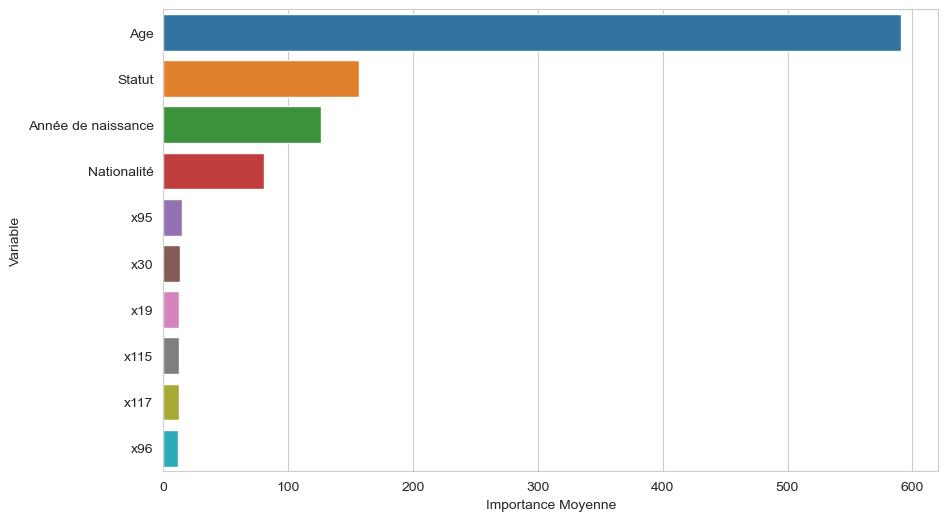

In [42]:
sns.set_style("whitegrid")
sorted_avg_features_imp = dict(sorted(avg_features_imp.items(), key=lambda x: x[1], reverse=True)[:10])
df_feat_imp = pd.DataFrame.from_dict(sorted_avg_features_imp, orient='index', columns=['Moyenne'])
df_feat_imp.reset_index(inplace=True)
df_feat_imp.rename(columns={'index': 'Variable'}, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Moyenne', y='Variable', data=df_feat_imp, orient='h')
plt.xlabel('Importance Moyenne')
plt.ylabel('Variable')
plt.show()

### Without Embedding

In [18]:
%%time
clf = CustomXGBPredictor(sample_weight = True)

mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc = TSCV_procedure_noembedding(n_splits = 5,
                                                                                                                                                                                                                        classifier = clf,
                                                                                                                                                                                                                        get_features_importance = False,
                                                                                                                                                                                                                        )
print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Mean Train Accuracy: 0.8576126591811238
Mean Train Balanced Accuracy: 0.8774785319647197
Mean Train Recall: 0.9410767790488477
Mean Train Precision: 0.722999367554883
Mean Train F1 Score: 0.8176199344041173
Mean Train AUC: 0.9388012757942457

Mean Validation Accuracy: 0.8051063829787234
Mean Validation Balanced Accuracy: 0.8216415176894738
Mean Validation Recall: 0.8926534830019248
Mean Validation Precision: 0.6956201703245722
Mean Validation F1 Score: 0.7794736015576824
Mean Validation AUC: 0.8485317681414373
CPU times: total: 9.02 s
Wall time: 3.71 s


### Fine tuning

In [22]:
classifier = CustomXGBPredictor(sample_weight = True)

param_space = {
    'custom_threshold': Real(0.1, 0.9, 'uniform'),
    'learning_rate': Real(0.005, 0.2, 'log-uniform'),
    'n_estimators': Integer(500, 5000),
    'max_depth': Integer(3, 30),
    'max_leaves': Integer(0,200),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0, 0.02, 'uniform'),
    'min_child_weight': Integer(0, 10),
    'reg_lambda': Real(0, 100, 'uniform')
}

tscv = TimeSeriesSplit(n_splits = 5)

np.int = int
X_train = EMBEDDING_DATA.df_train_clean[["age", "nationality", "civil_status", "birth_date"]].values
y_train = EMBEDDING_DATA.df_train_clean[["y"]].values
search = BayesSearchCV(classifier, param_space, n_iter = 80, scoring='balanced_accuracy', cv = tscv)
search.fit(X_train, y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=CustomXGBPredictor(sample_weight=True), n_iter=80,
              scoring='balanced_accuracy',
              search_spaces={'colsample_bytree': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'custom_threshold': Real(low=0.1, high=0.9, prior='uniform', transform='normalize'),
                             'g...
                             'max_leaves': Integer(low=0, high=200, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=0, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=500, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=100, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [23]:
print("Best hyperparameters:", search.best_params_)
print("Best balanced accuracy : ", search.best_score_)

Best hyperparameters: OrderedDict([('colsample_bytree', 1.0), ('custom_threshold', 0.5105831520393792), ('gamma', 0.02), ('learning_rate', 0.005), ('max_depth', 7), ('max_leaves', 0), ('min_child_weight', 9), ('n_estimators', 5000), ('reg_lambda', 54.06025501965432), ('subsample', 1.0)])
Best balanced accuracy :  0.8195872002164866


In [11]:
%%time
clf = CustomXGBPredictor(sample_weight = True,
                         custom_threshold = 0.5,
                         learning_rate = 0.005,
                         n_estimators = 5000,
                         max_depth = 7,
                         max_leaves = 0,
                         subsample = 1,
                         colsample_bytree = 1,
                         gamma = 0.02,
                         min_child_weight = 9,
                         reg_lambda = 54.06)
                         
mean_train_acc, mean_train_bal_acc, mean_train_rec, mean_train_prec, mean_train_f1, mean_train_auc, mean_val_acc, mean_val_bal_acc, mean_val_rec, mean_val_prec, mean_val_f1, mean_val_auc = TSCV_procedure_noembedding(n_splits = 5,
                                                                                                                                                                                                                        classifier = clf,
                                                                                                                                                                                                                        get_features_importance = False,
                                                                                                                                                                                                                        )
print("Mean Train Accuracy:", mean_train_acc)
print("Mean Train Balanced Accuracy:", mean_train_bal_acc)
print("Mean Train Recall:", mean_train_rec)
print("Mean Train Precision:", mean_train_prec)
print("Mean Train F1 Score:", mean_train_f1)
print("Mean Train AUC: {}\n".format(mean_train_auc))

print("Mean Validation Accuracy:", mean_val_acc)
print("Mean Validation Balanced Accuracy:", mean_val_bal_acc)
print("Mean Validation Recall:", mean_val_rec)
print("Mean Validation Precision:", mean_val_prec)
print("Mean Validation F1 Score:", mean_val_f1)
print("Mean Validation AUC:", mean_val_auc)

Mean Train Accuracy: 0.8325818510220001
Mean Train Balanced Accuracy: 0.8501362844431334
Mean Train Recall: 0.9089531628960378
Mean Train Precision: 0.693049311896375
Mean Train F1 Score: 0.7864022922923792
Mean Train AUC: 0.9090181952187374

Mean Validation Accuracy: 0.8114893617021277
Mean Validation Balanced Accuracy: 0.8267203093065495
Mean Validation Recall: 0.8887853040693827
Mean Validation Precision: 0.7055688026861178
Mean Validation F1 Score: 0.7836702882641084
Mean Validation AUC: 0.8593062001620522
CPU times: total: 1min 12s
Wall time: 9.9 s


### Test prediction

In [27]:
clf = CustomXGBPredictor(sample_weight = True,
                         custom_threshold = 0.5,
                         learning_rate = 0.005,
                         n_estimators = 5000,
                         max_depth = 7,
                         max_leaves = 0,
                         subsample = 1,
                         colsample_bytree = 1,
                         gamma = 0.02,
                         min_child_weight = 9,
                         reg_lambda = 54.06)

sto_clf = StoClassifier(classifier = clf)

X_train, X_test = sto_clf.fit_no_embedding(embedding_data = EMBEDDING_DATA,
                                           col_target = "y")

y_pred_train_unk, proba_pred_train_unk, y_pred_test_unk, proba_pred_test_unk = sto_clf.predict(predict_proba = True)

acc_train_unk = accuracy_score(train_df_link_unknown["y"], y_pred_train_unk)
bal_acc_train_unk = balanced_accuracy_score(train_df_link_unknown["y"], y_pred_train_unk)
recall_train_unk = recall_score(train_df_link_unknown["y"], y_pred_train_unk)
precision_train_unk = precision_score(train_df_link_unknown["y"], y_pred_train_unk)
f1_train_unk = f1_score(train_df_link_unknown["y"], y_pred_train_unk)
auc_train_unk = roc_auc_score(train_df_link_unknown["y"], proba_pred_train_unk)

acc_test_unk = accuracy_score(test_df_link_unknown["y"], y_pred_test_unk)
bal_acc_test_unk = balanced_accuracy_score(test_df_link_unknown["y"], y_pred_test_unk)
recall_test_unk = recall_score(test_df_link_unknown["y"], y_pred_test_unk)
precision_test_unk = precision_score(test_df_link_unknown["y"], y_pred_test_unk)
f1_test_unk = f1_score(test_df_link_unknown["y"], y_pred_test_unk)
auc_test_unk = roc_auc_score(test_df_link_unknown["y"], proba_pred_test_unk)

print("Train Accuracy - Link Unknown: {}".format(acc_train_unk))
print("Train Balanced Accuracy - Link Unknown: {}".format(bal_acc_train_unk))
print("Train Recall - Link Unknown: {}".format(recall_train_unk))
print("Train Precision - Link Unknown: {}".format(precision_train_unk))
print("Train F1-score - Link Unknown: {}".format(f1_train_unk))
print("Train AUC - Link Unknown: {}\n".format(auc_train_unk))

print("Test Accuracy - Link Unknown: {}".format(acc_test_unk))
print("Test Balanced Accuracy - Link Unknown: {}".format(bal_acc_test_unk))
print("Test Recall - Link Unknown: {}".format(recall_test_unk))
print("Test Precision - Link Unknown: {}".format(precision_test_unk))
print("Test F1-score - Link Unknown: {}".format(f1_test_unk))
print("Test AUC - Link Unknown: {}".format(auc_test_unk))

Train Accuracy - Link Unknown: 0.8233628318584071
Train Balanced Accuracy - Link Unknown: 0.842050158593624
Train Recall - Link Unknown: 0.9138755980861244
Train Precision - Link Unknown: 0.7001466275659824
Train F1-score - Link Unknown: 0.7928601079286011
Train AUC - Link Unknown: 0.8932224073974518

Test Accuracy - Link Unknown: 0.8029525032092426
Test Balanced Accuracy - Link Unknown: 0.8375938409682856
Test Recall - Link Unknown: 0.930327868852459
Test Precision - Link Unknown: 0.624484181568088
Test F1-score - Link Unknown: 0.7473251028806586
Test AUC - Link Unknown: 0.8579190286502222


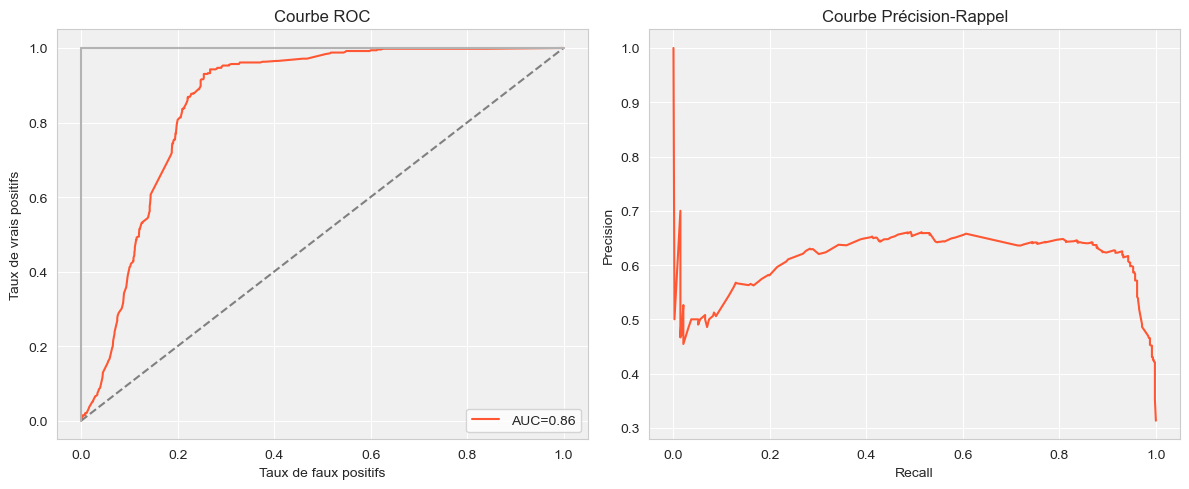

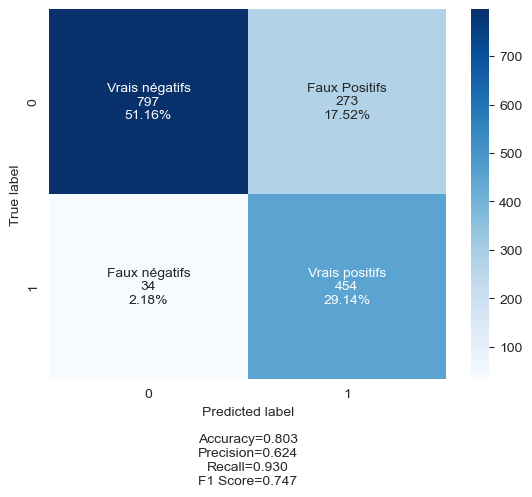

In [47]:
line_color = '#FF5733'
bg_color = '#f0f0f0'

FP_rate, TP_rate, _ = roc_curve(test_df_link_unknown["y"], proba_pred_test_unk)
prec, rec, _ = precision_recall_curve(test_df_link_unknown["y"], proba_pred_test_unk)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(FP_rate, TP_rate, label="AUC="+str(round(auc_test_unk, 2)), color=line_color)
plt.plot([0, 1], ls="--", color='gray')
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.title('Courbe ROC')
plt.legend(loc=4)
plt.grid(True, color='white')
plt.gca().set_facecolor(bg_color)

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color=line_color)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Courbe Précision-Rappel')
plt.grid(True, color='white')
plt.gca().set_facecolor(bg_color)

plt.tight_layout()
plt.savefig("roc_precrecall.png", bbox_inches="tight")
plt.show()

r = confusion_matrix(test_df_link_unknown["y"], y_pred_test_unk)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )

# Final Model

C:\Users\yanis\AppData\Local\Temp\ipykernel_144628\3813605661.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_link_known["y_pred"] = y_pred_test_known
C:\Users\yanis\AppData\Local\Temp\ipykernel_144628\3813605661.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_link_unknown["y_pred"] = y_pred_test_unk


Test Accuracy : 0.900053163211058
Test Balanced Accuracy : 0.9180099641915136
Test Recall : 0.9466950959488273
Test Precision : 0.6630164260826281
Test F1-score : 0.7798594847775175


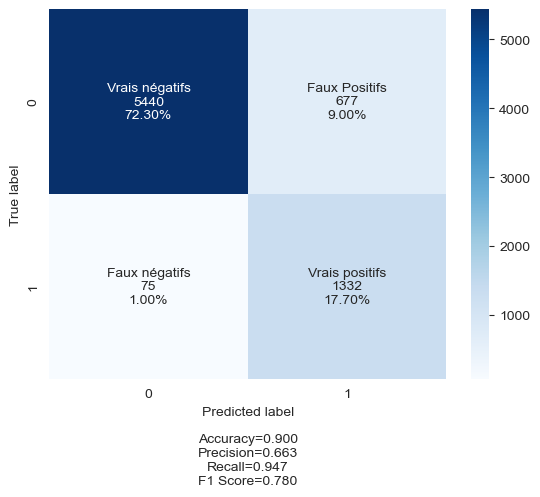

In [39]:
#Split test dataset: link is known vs link is unknown 
test_df_link_known = test_df[~test_df["link"].isna()]
test_df_link_unknown = test_df[test_df["link"].isna()]
# concatenated_df = pd.concat([train_df_link_unknown, train_df_link_known]).sort_index()

#Classifier for samples where link is known
regclassifier_test = RegexClassifier(df = test_df_link_known,
                                     col_link = "link")

y_pred_test_known = regclassifier_test.predict()

#Process data for which link is unknown
EMBEDDING_DATA = EmbeddingData(df_train = train_df_link_unknown,
                               df_test = test_df_link_unknown,
                               col_age = "age",
                               col_civil_status = "civil_status",
                               col_birth_date = "birth_date",
                               col_nationality = "nationality",
                               col_occupation = "occupation",
                               col_firstname = "firstname",
                               col_surname = "surname"
                               )

EMBEDDING_DATA.clean_train_dataframe()
EMBEDDING_DATA.clean_test_dataframe()

#Classifier for samples where link is unknown
clf = CustomXGBPredictor(sample_weight = True,
                         custom_threshold = 0.5,
                         learning_rate = 0.005,
                         n_estimators = 5000,
                         max_depth = 7,
                         max_leaves = 0,
                         subsample = 1,
                         colsample_bytree = 1,
                         gamma = 0.02,
                         min_child_weight = 9,
                         reg_lambda = 54.06)

sto_clf = StoClassifier(classifier = clf)

#Fit classifier with age, nationality, birth date and civil statuts variables
sto_clf.fit_no_embedding(embedding_data = EMBEDDING_DATA,
                         col_target = "y",
                         return_x_train = False,
                         return_x_test = False)

#Predict on test samples for which link is unknown
_, y_pred_test_unk = sto_clf.predict(predict_proba = False)

test_df_link_known["y_pred"] = y_pred_test_known
test_df_link_unknown["y_pred"] = y_pred_test_unk

test_df_with_pred = pd.concat([test_df_link_known, test_df_link_unknown]).sort_index()

acc_test = accuracy_score(test_df_with_pred["y"], test_df_with_pred["y_pred"])
bal_acc_test = balanced_accuracy_score(test_df_with_pred["y"], test_df_with_pred["y_pred"])
recall_test = recall_score(test_df_with_pred["y"], test_df_with_pred["y_pred"])
precision_test = precision_score(test_df_with_pred["y"], test_df_with_pred["y_pred"])
f1_test = f1_score(test_df_with_pred["y"], test_df_with_pred["y_pred"])

print("Test Accuracy : {}".format(acc_test))
print("Test Balanced Accuracy : {}".format(bal_acc_test))
print("Test Recall : {}".format(recall_test))
print("Test Precision : {}".format(precision_test))
print("Test F1-score : {}".format(f1_test))

r_test = confusion_matrix(test_df_with_pred["y"], test_df_with_pred["y_pred"])

make_confusion_matrix(r_test,
                      group_names=labels,
                      categories=categories,
                      )